# 数据导入

In [1]:
# #data_download
# import os
# import json
# import pandas as pd
# import yfinance as yf


# def fetch_stock_data(symbol, start_date, end_date):
#     stock_data = yf.download(symbol, start_date, end_date)
#     if stock_data.empty:
#         return None
#     stock_data = stock_data[stock_data.Volume >= 10]
#     business_days = pd.bdate_range(stock_data.index[0], stock_data.index[-1])
#     stock_data = stock_data.reindex(business_days)
#     stock_data.index.name = "Date"
#     stock_data["Adj Close"] = stock_data["Adj Close"].interpolate(method="linear")
#     return stock_data


# def download_stocks(
#     symbol_dict,
#     start_date="2001-01-01",
#     end_date="2021-11-30",
#     min_data_length=5000,
#     max_stocks=50,
#     save_dir="data/stocks/"
# ):
#     os.makedirs(save_dir, exist_ok=True)
#     downloaded_stocks = {}
#     count = 0

#     for symbol, company in symbol_dict.items():
#         symbol = "BRK-B" if symbol == "BRK.B" else symbol
#         stock_data = fetch_stock_data(symbol, start_date, end_date)
        
#         if stock_data is None or len(stock_data) <= min_data_length:
#             print(f"Failed to download {symbol}")
#             continue

#         stock_data.to_csv(os.path.join(save_dir, f"{symbol}.csv"))
#         downloaded_stocks[symbol] = company
#         count += 1
#         print(f"Downloaded {symbol}")

#         if count >= max_stocks:
#             break

#     return downloaded_stocks


# if __name__ == "__main__":
#     with open("config/data_config.json", "r", encoding="utf8") as config_file:
#         config = json.load(config_file)

#     snp500_df = pd.read_csv("data/snp500.csv")
#     snp500_df.loc[snp500_df.Symbol == "BRK.B", "Symbol"] = "BRK-B"
#     snp500_dict = {row[2]: row[1] for row in snp500_df.itertuples(index=False)}

#     downloaded_stocks = download_stocks(
#         snp500_dict, 
#         start_date=config["START"], 
#         end_date=config["END"], 
#         min_data_length=config["LEN_DATA"], 
#         max_stocks=config["N_STOCK"], 
#         save_dir='data/stocks/'
#     )

#     sp500_data = yf.download("^GSPC", config["START"], config["END"])
#     sp500_data.to_csv("data/snp500_index.csv")

#     with open("data/stock.json", "w", encoding="UTF-8") as stock_file:
#         json.dump(downloaded_stocks, stock_file)


In [2]:
# #make_dataset
# import json
# import pickle
# import numpy as np
# import pandas as pd


# def compute_return_dataframe(stock_dict, input_path="data/stocks/", output_path="data/"):
#     for index, ticker in enumerate(stock_dict):
#         stock_file = os.path.join(input_path, f"{ticker}.csv")
#         stock_data = pd.read_csv(stock_file, index_col="Date")[["Adj Close"]]
#         if index == 0:
#             return_data = np.log(stock_data) - np.log(stock_data.shift(1))
#             return_data.columns = [ticker]
#         else:
#             return_data[ticker] = np.log(stock_data) - np.log(stock_data.shift(1))
#     return_data = return_data.dropna()
#     return_data.to_csv(os.path.join(output_path, "return_df.csv"))
#     return return_data


# def create_DL_dataset(data, sequence_length, num_stocks):
#     time_indices = []
#     dataset = np.array(data.iloc[:sequence_length, :]).reshape(1, -1, num_stocks)
#     time_indices.append(data.iloc[:sequence_length, :].index)

#     for start in range(1, len(data) - sequence_length + 1):
#         new_sequence = np.array(data.iloc[start:sequence_length + start, :]).reshape(1, -1, num_stocks)
#         dataset = np.concatenate((dataset, new_sequence))
#         time_indices.append(data.iloc[start:sequence_length + start, :].index)
#     return dataset, time_indices


# def split_data(data, train_length, predict_length, train_ratio, num_stocks):
#     train_data = data[: int(len(data) * train_ratio)]
#     test_data = data[int(len(data) * train_ratio) :]

#     train_set, train_times = create_DL_dataset(train_data, train_length + predict_length, num_stocks)
#     test_set, test_times = create_DL_dataset(test_data, train_length + predict_length, num_stocks)

#     x_train = np.array([seq[:train_length] for seq in train_set])
#     y_train = np.array([seq[-predict_length:] for seq in train_set])
#     train_times = np.unique([time[-predict_length:] for time in train_times]).tolist()

#     x_test = np.array([seq[:train_length] for seq in test_set])
#     y_test = np.array([seq[-predict_length:] for seq in test_set])
#     test_times = np.unique([time[-predict_length:] for time in test_times]).tolist()

#     return x_train, y_train, x_test, y_test, train_times, test_times


# if __name__ == "__main__":
#     base_path = "data/"
#     with open("config/data_config.json", "r", encoding="utf8") as config_file:
#         config = json.load(config_file)

#     with open(os.path.join(base_path, "stock.json"), "r", encoding="UTF8") as stock_file:
#         stock_dict = json.load(stock_file)

#     return_df = compute_return_dataframe(stock_dict)
#     x_train, y_train, x_test, y_test, train_times, test_times = split_data(
#         return_df,
#         config["TRAIN_LEN"],
#         config["PRED_LEN"],
#         config["TRAIN_RATIO"],
#         config["N_STOCK"]
#     )

#     with open(os.path.join(base_path, "date.pkl"), "wb") as date_file:
#         pickle.dump(test_times, date_file)

#     with open(os.path.join(base_path, "dataset.pkl"), "wb") as dataset_file:
#         pickle.dump([x_train, y_train, x_test, y_test], dataset_file)


# 模型导入

In [3]:
import torch
import numpy as np
import pickle

def calculate_max_sharpe_ratio(returns, weights):
    # 将权重添加一个维度
    weights = weights.unsqueeze(1)
    # 计算平均收益并添加一个维度
    mean_returns = torch.mean(returns, axis=1).unsqueeze(2)
    # 计算协方差矩阵，并将其转换到权重的设备
    covariances = torch.stack([torch.Tensor(np.cov(batch.cpu().T, ddof=0)) for batch in returns]).to(weights.device)
    # 计算投资组合的收益
    portfolio_returns = weights.matmul(mean_returns)
    # 计算投资组合的波动率
    portfolio_volatilities = weights.matmul(covariances).matmul(weights.transpose(2, 1))
    # 计算夏普比率
    sharpe_ratios = (portfolio_returns * 12 - 0.02) / (torch.sqrt(portfolio_volatilities * 12))
    # 返回负的平均夏普比率（用于最小化损失函数）
    return -sharpe_ratios.mean()

In [4]:
def calculate_equal_risk_parity(returns, weights):
    # 获取批次大小和特征数量
    batch_size, _, num_features = returns.shape
    # 将权重添加一个维度并转换到返回的设备
    weights = weights.unsqueeze(1).to(returns.device)
    # 计算协方差矩阵，并将其转换到返回的设备
    covariances = torch.stack([torch.Tensor(np.cov(batch.cpu().T, ddof=0)) for batch in returns]).to(returns.device)
    # 计算投资组合的波动率
    portfolio_volatility = torch.sqrt(weights.matmul(covariances).matmul(weights.transpose(2, 1)))
    # 计算边际风险贡献
    marginal_risk_contributions = (1 / portfolio_volatility) * (covariances.matmul(weights.transpose(2, 1)))
    # 计算风险贡献
    risk_contributions = weights.view(batch_size, num_features) * marginal_risk_contributions.view(batch_size, num_features)
    # 目标风险贡献均等
    target_risk = (torch.ones((batch_size, num_features)) / num_features).to(returns.device)
    # 计算风险差异
    risk_differences = risk_contributions - target_risk
    # 计算风险差异平方和的平均值
    risk_diff_squared_sum = risk_differences.square().mean()
    # 返回风险差异平方和的平均值（用于最小化损失函数）
    return risk_diff_squared_sum

In [5]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        if rho < 0.0:  # 如果 rho 是负数，则抛出异常
            raise ValueError(f"Invalid rho value: {rho}. It should be non-negative.")
        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
    @torch.no_grad()  # 禁用梯度计算
    def first_step(self, zero_grad=False):
        grad_norm = self._compute_grad_norm()  # 计算梯度范数
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)  # 计算缩放比例
            for p in group["params"]:
                if p.grad is None:  # 如果没有梯度，则跳过
                    continue
                perturbation = p.grad * scale.to(p.device)  # 计算扰动
                p.add_(perturbation)  # 添加扰动到参数
                self.state[p]["perturbation"] = perturbation  # 存储扰动
        if zero_grad:
            self.zero_grad()  # 清零梯度
    @torch.no_grad()  # 禁用梯度计算
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:  # 如果没有梯度，则跳过
                    continue
                p.sub_(self.state[p]["perturbation"])  # 从参数中减去扰动
        self.base_optimizer.step()  # 执行基础优化器的 step 方法
        if zero_grad:
            self.zero_grad()  # 清零梯度
    def step(self, closure=None):
        raise NotImplementedError(
            "SAM requires `first_step` and `second_step` calls; refer to the documentation for details."
        )
    def _compute_grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # 获取设备
        grad_norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2).to(shared_device)
                for group in self.param_groups
                for p in group["params"]
                if p.grad is not None  # 只考虑有梯度的参数
            ]), 
            p=2  # 使用 L2 范数
        )
        return grad_norm

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class CustomGRU(nn.Module):
    def __init__(self, num_layers, hidden_size, num_stocks, dropout_rate=0.3, bidirectional=False, lower_bound=0, upper_bound=0.1):
        super(CustomGRU, self).__init__()
        self.num_layers = num_layers  # GRU层数
        self.hidden_size = hidden_size  # 隐藏层大小
        self.lower_bound = lower_bound  # 权重下限
        self.upper_bound = upper_bound  # 权重上限
        self.bidirectional = bidirectional  # 是否使用双向GRU
        # 定义GRU层
        self.gru = nn.GRU(
            input_size=num_stocks, hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional
        )
        self.dropout = nn.Dropout(dropout_rate)  # 定义Dropout层
        self.scale = 2 if self.bidirectional else 1  # 如果是双向GRU，则缩放因子为2
        self.fc = nn.Linear(self.hidden_size * self.scale, num_stocks)  # 定义全连接层
        self.activation = nn.SiLU()  # 定义激活函数
    def forward(self, x):
        batch_size = x.size(0)  # 获取批次大小
        init_hidden = torch.zeros(self.num_layers * self.scale, batch_size, self.hidden_size).to(x.device)  # 初始化隐藏状态
        gru_out, _ = self.gru(x, init_hidden)  # 通过GRU层
        last_hidden = gru_out[:, -1, :]  # 取最后一个时间步的隐藏状态
        out = self.fc(self.dropout(last_hidden))  # 通过Dropout层和全连接层
        out = self.activation(out)  # 通过激活函数
        out = F.softmax(out, dim=-1)  # 通过Softmax函数
        out = torch.stack([self.rebalance_weights(batch, self.lower_bound, self.upper_bound) for batch in out])  # 调整权重
        return out
    def rebalance_weights(self, weights, lower_bound, upper_bound):
        clamped_weights = torch.clamp(weights, lower_bound, upper_bound)  # 限制权重在上下限之间
        while True:
            excess = (weights - clamped_weights).sum().item()  # 计算超出部分
            adjustable_weights = clamped_weights[clamped_weights != upper_bound]  # 获取可调整的权重
            adjustment = excess * (adjustable_weights / adjustable_weights.sum())  # 计算调整量
            clamped_weights[clamped_weights != upper_bound] += adjustment  # 调整权重
            weights = clamped_weights  # 更新权重
            if len(torch.where(clamped_weights > upper_bound)[0]) == 0:  # 如果所有权重都在上限内，跳出循环
                break
            clamped_weights = torch.clamp(weights, lower_bound, upper_bound)  # 再次限制权重在上下限之间
        return clamped_weights  # 返回调整后的权重

In [7]:
import torch
from torch import nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
class TemporalConvNet(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(output_channels)
        for i in range(num_levels):
            dilation = 2 ** i  # 膨胀因子
            in_channels = input_channels if i == 0 else output_channels[i - 1]
            out_channels = output_channels[i]
            layers.append(
                TemporalBlock(
                    in_channels, out_channels, kernel_size, stride=1,
                    dilation=dilation, padding=(kernel_size - 1) * dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)  # 使用 nn.Sequential 构建网络
    def forward(self, x):
        return self.network(x)  # 前向传播
class TemporalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(input_channels, output_channels, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)  # 移除填充部分
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(output_channels, output_channels, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)  # 移除填充部分
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(input_channels, output_channels, 1) if input_channels != output_channels else None
        self.final_relu = nn.ReLU()
        self._init_weights()  # 初始化权重
    def _init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)  # 初始化卷积层权重
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
    def forward(self, x):
        out = self.net(x)  # 通过网络
        residual = x if self.downsample is None else self.downsample(x)  # 残差连接
        return self.final_relu(out + residual)  # 输出经过ReLU激活函数
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()  # 移除填充部分
class TCN(nn.Module):
    def __init__(self, input_features, output_features, channels, kernel_size, dropout, time_steps, lb, ub):
        super(TCN, self).__init__()
        self.input_features = input_features
        self.tcn = TemporalConvNet(input_features, channels, kernel_size, dropout)
        self.fc = nn.Linear(channels[-1], output_features)  # 全连接层
        self.max_pool = nn.MaxPool1d(time_steps)  # 最大池化层
        self.lb = lb  # 权重下限
        self.ub = ub  # 权重上限
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2))  # 通过时间卷积网络
        output = self.max_pool(output).squeeze(-1)  # 最大池化
        output = self.fc(output)  # 全连接层
        output = F.softmax(output, dim=1)  # Softmax层
        output = torch.stack([self.rebalance_weights(batch, self.lb, self.ub) for batch in output])  # 调整权重
        return output
    def rebalance_weights(self, weights, lb, ub):
        clamped_weights = torch.clamp(weights, lb, ub)  # 限制权重在上下限之间
        while True:
            excess = (weights - clamped_weights).sum().item()  # 计算超出部分
            adjustable_weights = clamped_weights[clamped_weights != ub]  # 获取可调整的权重
            adjustment = excess * (adjustable_weights / adjustable_weights.sum())  # 计算调整量
            clamped_weights[clamped_weights != ub] += adjustment  # 调整权重
            weights = clamped_weights  # 更新权重
            if len(clamped_weights[clamped_weights > ub]) == 0:  # 如果所有权重都在上限内，跳出循环
                break
            clamped_weights = torch.clamp(weights, lb, ub)  # 再次限制权重在上下限之间
        return clamped_weights  # 返回调整后的权重

In [8]:
#transformer
import torch
import torch.nn as nn
import copy
import math
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# 创建掩码
def create_mask(batch_size, seq_len):
    # 创建一个大小为 (batch_size, seq_len, seq_len) 的零矩阵
    mask = torch.zeros(batch_size, seq_len, seq_len)
    # 遍历序列长度
    for i in range(seq_len):
        # 将掩码的前 i+1 个位置设置为 1
        mask[:, i, :i + 1] = 1
    # 返回掩码
    return mask
# 定义归一化层
class Normalization(nn.Module):
    def __init__(self, model_dim, eps=1e-6):
        # 调用父类的构造函数
        super(Normalization, self).__init__()
        # 模型维度
        self.size = model_dim
        # 初始化缩放参数 alpha 和偏置参数 bias
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        # 设置一个很小的数以防除以零
        self.eps = eps
    def forward(self, x):
        # 计算均值，维度保持不变
        mean = x.mean(dim=-1, keepdim=True)
        # 计算标准差，维度保持不变
        std = x.std(dim=-1, keepdim=True)
        # 执行归一化
        normed = self.alpha * (x - mean) / (std + self.eps) + self.bias
        # 返回归一化后的张量
        return normed

In [10]:
# 定义缩放点积注意力机制
def scaled_dot_product_attention(q, k, v, d_k, mask=None, dropout=None, return_weights=False):
    # 计算注意力得分矩阵，q 和 k 转置后相乘并除以 d_k 的平方根
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    # 如果有掩码
    if mask is not None:
        # 扩展掩码维度
        mask = mask.unsqueeze(1)
        # 将掩码为 0 的位置填充一个非常小的值（负无穷），避免这些位置影响注意力计算
        scores = scores.masked_fill(mask == 0, -1e9)
    # 对得分矩阵应用 softmax 函数，沿最后一个维度计算注意力权重
    attn = F.softmax(scores, dim=-1)
    # 如果有 dropout 层，则对注意力权重应用 dropout
    if dropout is not None:
        attn = dropout(attn)
    # 计算最终的注意力输出，attn 和 v 相乘
    output = torch.matmul(attn, v)
    # 如果需要返回注意力权重，则返回输出和权重
    if return_weights:
        return output, attn
    # 否则只返回输出
    return output

In [11]:
# 定义多头注意力机制类
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, model_dim, dropout=0.1):
        # 调用父类的构造函数
        super(MultiHeadAttention, self).__init__()
        # 设置头数
        self.num_heads = num_heads
        # 计算每个头的维度
        self.d_k = model_dim // num_heads
        # 模型的维度
        self.model_dim = model_dim
        # 定义查询、键和值的线性变换层
        self.q_linear = nn.Linear(model_dim, model_dim)
        self.k_linear = nn.Linear(model_dim, model_dim)
        self.v_linear = nn.Linear(model_dim, model_dim)
        # 定义 dropout 层
        self.dropout = nn.Dropout(dropout)
        # 定义输出的线性变换层
        self.out = nn.Linear(model_dim, model_dim)
    def forward(self, q, k, v, mask=None, return_weights=False):
        # 获取批次大小
        batch_size = q.size(0)
        # 对查询、键和值进行线性变换，并分割成多头，改变视图以便计算注意力
        q = self.q_linear(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        # 如果需要返回注意力权重
        if return_weights:
            # 计算注意力输出和权重
            attn_output, attn_weights = scaled_dot_product_attention(q, k, v, self.d_k, mask, self.dropout, return_weights)
        else:
            # 只计算注意力输出
            attn_output = scaled_dot_product_attention(q, k, v, self.d_k, mask, self.dropout)
        # 将多头注意力输出合并回单个张量
        concat = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.model_dim)
        # 通过输出线性层
        output = self.out(concat)
        # 如果需要返回注意力权重，则返回输出和权重
        if return_weights:
            return output, attn_weights
        # 否则只返回输出
        return output

In [12]:
# 定义前馈神经网络类
class FeedForward(nn.Module):
    def __init__(self, model_dim, ff_dim=400, dropout=0.1):
        # 调用父类的构造函数
        super(FeedForward, self).__init__()
        # 定义第一个线性变换层，将输入维度从 model_dim 转换为 ff_dim
        self.linear1 = nn.Linear(model_dim, ff_dim)
        # 定义 dropout 层
        self.dropout = nn.Dropout(dropout)
        # 定义第二个线性变换层，将维度从 ff_dim 转换回 model_dim
        self.linear2 = nn.Linear(ff_dim, model_dim)
    def forward(self, x):
        # 第一个线性变换后应用 ReLU 激活函数和 dropout
        x = self.dropout(F.relu(self.linear1(x)))
        # 第二个线性变换
        x = self.linear2(x)
        # 返回输出
        return x

In [13]:
# 定义编码器层类
class EncoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads, dropout=0.1):
        # 调用父类的构造函数
        super(EncoderLayer, self).__init__()
        # 定义第一个归一化层
        self.norm1 = Normalization(model_dim)
        # 定义第二个归一化层
        self.norm2 = Normalization(model_dim)
        # 定义多头注意力机制层
        self.attn = MultiHeadAttention(num_heads, model_dim, dropout)
        # 定义前馈神经网络层
        self.ff = FeedForward(model_dim, dropout=dropout)
        # 定义两个 dropout 层
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x, mask=None, return_weights=False):
        # 第一次归一化处理
        x2 = self.norm1(x)
        # 计算注意力输出，如果需要返回注意力权重
        if return_weights:
            attn_output, attn_weights = self.attn(x2, x2, x2, mask, return_weights=return_weights)
        else:
            attn_output = self.attn(x2, x2, x2, mask)
        # 将注意力输出和原始输入相加，并应用 dropout
        x = x + self.dropout1(attn_output)
        # 第二次归一化处理
        x2 = self.norm2(x)
        # 通过前馈神经网络层，并与输入相加，应用 dropout
        x = x + self.dropout2(self.ff(x2))
        # 如果需要返回注意力权重，则返回输出和权重
        if return_weights:
            return x, attn_weights
        # 否则只返回输出
        return x

In [14]:
# 定义位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_seq_len=100, dropout=0.1):
        # 调用父类的构造函数
        super(PositionalEncoding, self).__init__()
        # 定义 dropout 层
        self.dropout = nn.Dropout(dropout)
        # 初始化位置编码矩阵 pe，大小为 (max_seq_len, model_dim)
        pe = torch.zeros(max_seq_len, model_dim)
        # 生成位置索引
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        # 计算位置编码中的除法项
        div_term = torch.exp(torch.arange(0, model_dim, 2) * -(math.log(10000.0) / model_dim))
        # 计算 sin 编码并赋值给 pe 的偶数列
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算 cos 编码并赋值给 pe 的奇数列
        pe[:, 1::2] = torch.cos(position * div_term)
        # 扩展位置编码矩阵的第一个维度
        pe = pe.unsqueeze(0)
        # 注册 pe 为 buffer，使其在模型保存和加载时不会被认为是模型参数
        self.register_buffer('pe', pe)
    def forward(self, x):
        # 将输入 x 的值乘以位置编码矩阵的最后一维的平方根，进行缩放
        x = x * math.sqrt(self.pe.size(-1))
        # 将位置编码矩阵加到输入 x 上
        x = x + self.pe[:, :x.size(1)].to(x.device)
        # 应用 dropout
        return self.dropout(x)

In [15]:
# 定义一个函数，用于克隆 N 个相同的模块
def get_clones(module, N):
    # 使用深度拷贝生成 N 个相同的模块，并返回一个 ModuleList
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
# 定义编码器类
class Encoder(nn.Module):
    def __init__(self, input_dim, seq_len, num_layers, num_heads, dropout):
        # 调用父类的构造函数
        super(Encoder, self).__init__()
        # 初始化位置编码
        self.pe = PositionalEncoding(input_dim, seq_len, dropout)
        # 生成多个编码器层，并将其放入 ModuleList
        self.layers = get_clones(EncoderLayer(input_dim, num_heads, dropout), num_layers)
        # 初始化归一化层
        self.norm = Normalization(input_dim)
    def forward(self, x, mask=None, return_weights=False):
        # 对输入进行位置编码
        x = self.pe(x)
        # 遍历每个编码器层
        for i, layer in enumerate(self.layers):
            # 如果是第一层且需要返回注意力权重
            if i == 0 and return_weights:
                # 计算注意力输出和权重
                x, weights = layer(x, mask, return_weights=return_weights)
            else:
                # 只计算注意力输出
                x = layer(x, mask)
        # 最终进行归一化处理
        if return_weights:
            # 返回归一化后的输出和注意力权重
            return self.norm(x), weights
        # 只返回归一化后的输出
        return self.norm(x)

In [16]:
# 定义 Transformer 类
class Transformer(nn.Module):
    def __init__(self, input_dim, seq_len, num_layers, num_heads, dropout, output_dim, lb, ub):
        # 调用父类的构造函数
        super(Transformer, self).__init__()
        # 初始化编码器
        self.encoder = Encoder(input_dim, seq_len, num_layers, num_heads, dropout)
        # 定义全连接层
        self.fc = nn.Linear(input_dim, output_dim)
        # 定义最大池化层
        self.max_pool = nn.MaxPool1d(seq_len)
        # 设置权重重平衡的下限和上限
        self.lb = lb
        self.ub = ub
    def forward(self, src, return_weights=False):
        # 创建掩码
        mask = create_mask(src.size(0), src.size(1)).to(device)
        # 如果需要返回注意力权重
        if return_weights:
            # 计算编码器输出和注意力权重
            encoder_output, attn_weights = self.encoder(src, mask, return_weights=return_weights)
        else:
            # 只计算编码器输出
            encoder_output = self.encoder(src, mask)
        # 对编码器输出进行最大池化，并去掉最后一个维度
        encoder_output = self.max_pool(encoder_output.transpose(1, 2)).squeeze(-1)
        # 通过全连接层
        output = self.fc(encoder_output)
        # 应用 softmax 函数
        output = F.softmax(output, dim=1)
        # 对输出的权重进行重平衡
        output = torch.stack([self._rebalance_weights(batch, self.lb, self.ub) for batch in output])
        # 如果需要返回注意力权重
        if return_weights:
            return output, attn_weights
        # 只返回输出
        return output
    # 定义权重重平衡函数
    def _rebalance_weights(self, weights, lb, ub):
        # 将权重限制在 lb 和 ub 之间
        clamped_weights = torch.clamp(weights, lb, ub)
        while True:
            # 计算超出部分的总和
            excess = (weights - clamped_weights).sum().item()
            # 获取所有小于上限的权重
            adjustable_weights = clamped_weights[clamped_weights != ub]
            # 计算调整量
            adjustment = excess * (adjustable_weights / adjustable_weights.sum())
            # 调整权重
            clamped_weights[clamped_weights != ub] += adjustment
            weights = clamped_weights
            # 如果所有权重都在上限以下，则退出循环
            if len(clamped_weights[clamped_weights > ub]) == 0:
                break
            # 再次将权重限制在 lb 和 ub 之间
            clamped_weights = torch.clamp(weights, lb, ub)
        # 返回重平衡后的权重
        return clamped_weights

In [17]:
import os
import torch
import torch.nn as nn
# 保存模型函数
def save_model(model, directory, filename):
    # 创建保存目录，如果不存在则创建
    os.makedirs(directory, exist_ok=True)
    # 如果模型是使用 DataParallel 并行化的，则获取其 module 的状态字典，否则直接获取模型的状态字典
    checkpoint = {"model_state_dict": model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()}
    # 保存模型到指定路径
    torch.save(checkpoint, os.path.join(directory, f"best_model_weight_{filename}.pt"))
# 去除前缀函数
def remove_prefix(state_dict, prefix):
    # 如果状态字典中的键以指定前缀开头，则去除该前缀
    return {key[len(prefix):] if key.startswith(prefix) else key: value for key, value in state_dict.items()}
# 加载模型函数
def load_model(model, filepath, use_cuda=True, set_eval=True):
    # 设置设备为 GPU 或 CPU
    device = "cuda" if use_cuda else "cpu"
    # 将模型移动到指定设备
    model = model.to(device)
    # 加载检查点
    checkpoint = torch.load(filepath, map_location=device)
    # 如果模型不是使用 DataParallel 并行化的，则去除状态字典中的 "module." 前缀
    state_dict = remove_prefix(checkpoint["model_state_dict"], "module.") if not isinstance(model, nn.DataParallel) else checkpoint["model_state_dict"]
    # 加载模型状态字典
    model.load_state_dict(state_dict, strict=False)
    # 如果设置为评估模式，则将模型设置为评估模式
    if set_eval:
        model.eval()
    # 返回模型
    return model

# 训练的函数

In [18]:
class ModelTrainer:
    def __init__(self, config):
        # 初始化函数，设置配置和设备
        self.config = config
        self.device = torch.device("cuda" if config["USE_CUDA"] else "cpu")
        self._initialize_model()
        
        # 设置优化器，使用SGD优化器和SAM自适应优化方法
        base_optimizer = torch.optim.SGD
        self.optimizer = SAM(
            self.model.parameters(), base_optimizer, lr=config["LR"], momentum=config['MOMENTUM']
        )
        
        # 损失函数，使用最大夏普比率作为损失函数
        self.criterion = calculate_max_sharpe_ratio

    def _initialize_model(self):
        # 初始化模型，根据配置选择不同的模型
        model_name = self.config["MODEL"].lower()
        if model_name == "gru":
            self.model = CustomGRU(
                self.config["N_LAYER"],
                self.config["HIDDEN_DIM"],
                self.config["N_FEAT"],
                self.config["DROPOUT"],
                self.config["BIDIRECTIONAL"],
                self.config['LB'], self.config['UB']
            ).to(self.device)
        elif model_name == "transformer":
            self.model = Transformer(
                self.config['TRANSFORMER']['n_feature'],
                self.config['TRANSFORMER']['n_timestep'],
                self.config['TRANSFORMER']["n_layer"],
                self.config['TRANSFORMER']["n_head"],
                self.config['TRANSFORMER']["n_dropout"],
                self.config['TRANSFORMER']["n_output"],
                self.config['LB'], self.config['UB']
            ).to(self.device)
        elif model_name == "tcn":
            hidden_size, level = 5, 3
            num_channels = [hidden_size] * (level - 1) + [self.config['TCN']['n_timestep']]
            self.model = TCN(
                self.config['TCN']['n_feature'],
                self.config['TCN']['n_output'],
                num_channels,
                self.config['TCN']["kernel_size"],
                self.config['TCN']["n_dropout"],
                self.config['TCN']["n_timestep"],
                self.config['LB'], self.config['UB'],
            ).to(self.device)

    def load_data(self):
        # 加载数据集
        with open("data/dataset.pkl", "rb") as f:
            self.train_x_raw, self.train_y_raw, self.test_x_raw, self.test_y_raw = pickle.load(f)

        with open("data/date.pkl", "rb") as f:
            self.test_date = pickle.load(f)

    def preprocess_data(self, scale=21):
        # 数据预处理，将数据缩放并转换为张量
        self.train_x = torch.from_numpy(self.train_x_raw.astype("float32") * scale)
        self.train_y = torch.from_numpy(self.train_y_raw.astype("float32") * scale)
        self.test_x = torch.from_numpy(self.test_x_raw.astype("float32") * scale)
        self.test_y = torch.from_numpy(self.test_y_raw.astype("float32") * scale)

    def set_parameters(self):
        # 设置训练和预测的长度以及股票数量
        self.LEN_TRAIN = self.train_x.shape[1]
        self.LEN_PRED = self.train_y.shape[1]
        self.N_STOCK = self.config["N_FEAT"]

    def shuffle_data(self):
        # 随机打乱训练数据
        indices = np.arange(len(self.train_x))
        np.random.shuffle(indices)
        self.train_x = self.train_x[indices]
        self.train_y = self.train_y[indices]

    def prepare_data(self):
        # 准备数据，依次调用加载、预处理和参数设置方法
        self.load_data()
        self.preprocess_data()
        self.set_parameters()
        self.shuffle_data()

    def create_dataloader(self, x, y):
        # 创建数据加载器
        dataset = torch.utils.data.TensorDataset(x, y)
        return torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=self.config["BATCH"],
            shuffle=False,
            drop_last=True,
        )

    def train_model(self, visualize=True):
        # 训练模型
        train_loader = self.create_dataloader(self.train_x, self.train_y)
        test_loader = self.create_dataloader(self.test_x, self.test_y)

        valid_losses, train_losses = [], []
        early_stop_counter, early_stop_threshold = 0, self.config["EARLY_STOP"]

        for epoch in range(self.config["EPOCHS"]):
            print(f"Epoch {epoch + 1}/{self.config['EPOCHS']}")
            print("-" * 10)
            for phase in ["train", "valid"]:
                dataloader = train_loader if phase == "train" else test_loader
                self.model.train() if phase == "train" else self.model.eval()

                running_loss = 0.0
                for x, y in dataloader:
                    x, y = x.to(self.device), y.to(self.device)
                    self.optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        predictions = self.model(x)
                        loss = self.criterion(y, predictions)
                        if phase == "train":
                            loss.backward()
                            self.optimizer.first_step(zero_grad=True)
                            self.criterion(y, self.model(x)).backward()
                            self.optimizer.second_step(zero_grad=True)

                    running_loss += loss.item() / len(dataloader)

                if phase == "train":
                    train_losses.append(running_loss)
                else:
                    valid_losses.append(running_loss)
                    if running_loss <= min(valid_losses):
                        save_model(self.model, "result", "best_model")
                        print(f"Validation loss improved at epoch {epoch + 1}: {running_loss:.4f}")
                        early_stop_counter = 0
                    else:
                        early_stop_counter += 1

                if early_stop_counter >= early_stop_threshold:
                    break

        if visualize:
            self._plot_training_curves(train_losses, valid_losses)

        return self.model, train_losses, valid_losses

    def _plot_training_curves(self, train_losses, valid_losses):
        # 绘制训练曲线
        plt.plot(train_losses, label="Train Loss")
        plt.plot(valid_losses, label="Valid Loss")
        plt.legend()
        plt.savefig("result/training_curves.png")
        plt.show()
    
    def backtest_model(self, visualize=True):
        # 回测模型表现
        portfolio_value = [10000]
        equal_weight_value = [10000]
        equal_weights = np.ones(self.N_STOCK) / self.N_STOCK
        model_weights = []
        first = True
        oldout = torch.randn(50).to(self.device).cpu().numpy()
        for i in range(0, self.test_x.shape[0], self.LEN_PRED):
            x = self.test_x[i][np.newaxis, :, :].float().to(self.device)
            with torch.no_grad():
                weights = self.model(x)[0].cpu().numpy()
            if first:
                oldout = weights
                first = False

            # 计算变化比例
            change_ratio = (weights - oldout) / oldout
            # 设定变化比例的上下限
            max_change_ratio = 0.1  # 10%
            # 限制变化比例在 [-max_change_ratio, max_change_ratio] 范围内
            change_ratio_clamped = np.clip(change_ratio, a_min=-max_change_ratio, a_max=max_change_ratio)

            # 根据限制后的变化比例计算新的仓位
            weights = oldout * (1 + change_ratio_clamped)
            model_weights.append(weights)
            oldout = weights

            # 获取当天的收益率
            returns = np.sum(self.test_y_raw[i], axis=0)

            # 计算投资组合的价值
            portfolio_value.append(portfolio_value[-1] * np.exp(np.dot(weights, returns)))
            equal_weight_value.append(equal_weight_value[-1] * np.exp(np.dot(equal_weights, returns)))

        performance = pd.DataFrame(
            {"EqualWeight": equal_weight_value, "Model": portfolio_value},
            index=self.test_date[::self.LEN_PRED]
        )
        index_sp = pd.DataFrame(
            pd.read_csv("data/snp500_index.csv", index_col="Date")["Adj Close"]
        )
        index_sp = index_sp[self.test_date[0] :]
        performance["index_sp"] = index_sp["Adj Close"] * (
            portfolio_value[0] / index_sp["Adj Close"][0]
        )
        performance.fillna(method='ffill', inplace=True)
        performance.to_csv("result/backtest_performance.csv")
        if visualize:
            self._plot_backtest_performance(performance)
            self._plot_model_weights(model_weights)

        return self._calculate_metrics(performance)


    def _plot_backtest_performance(self, performance):
        # 绘制回测表现曲线
        performance[:36].plot(figsize=(14, 7))
        plt.legend()
        plt.savefig("result/backtest_performance.png")
        plt.show()

    def _plot_model_weights(self, weights):
        # 绘制模型权重变化曲线
        weights = np.array(weights)
        tickers = pd.read_csv("data/return_df.csv", index_col=0).columns
        plt.figure(figsize=(15, 10))
        for i in range(weights.shape[1]):
            plt.plot(weights[:, i], label=tickers[i])
        plt.legend()
        plt.savefig("result/model_weights.png")
        plt.show()

    def _calculate_metrics(self, performance):
        # 计算回测表现指标
        log_returns = np.log(performance / performance.shift(1)).dropna()
        annualized_return = log_returns.mean() * 12
        annualized_volatility = log_returns.std() * np.sqrt(12)
        sharpe_ratio = annualized_return / annualized_volatility
        mdd = self._calculate_mdd(performance)
        print("Annualized Return:")
        print(annualized_return)
        print("Annualized Volatility:")
        print(annualized_volatility)
        print("Sharpe Ratio:")
        print(sharpe_ratio)
        print("Maximum Drawdown:")
        print(mdd)
        return {
            "annualized_return": annualized_return,
            "annualized_volatility": annualized_volatility,
            "sharpe_ratio": sharpe_ratio,
            "max_drawdown": mdd
        }

    def _calculate_mdd(self, series):
        # 计算最大回撤
        peak = series.cummax()
        drawdown = (series - peak) / peak
        mdd = drawdown.min()
        return mdd.idxmin(), mdd.min()

# 开始训练

In [19]:
config = {
    # 三个模型分别是：GRU，TCN和transfromer
  "MODEL": "GRU",
  "BATCH": 32,
  "SEED": 42,
  "EPOCHS": 10, # 可以修改
  "EARLY_STOP": 20, # 可以修改
  "LR": 0.025, # 可以修改
  "MOMENTUM": 0.95, # 可以修改
  "N_LAYER": 3, # 可以1/2/3修改，但是会极大增加模型复杂度和训练时间
  "HIDDEN_DIM": 128,
  "N_FEAT": 50,
  "USE_CUDA":True,
  "DROPOUT": 0.3, # 可以修改（可以先不改）
  "LB": 0,
  "UB": 0.2,
  "BIDIRECTIONAL":False,
    # 
  "TCN": {
    "n_feature": 50,
    "n_output": 50,
    "kernel_size": 4, # 可以修改
    "n_dropout": 0.1, # 可以修改（可以先不改）
    "n_timestep": 63 # 不太需要修改，但也可以修改
  },
  "TRANSFORMER": {
    "n_feature": 50,
    "n_timestep": 63, # 可以修改
    "n_layer": 6, # 可以修改
    "n_head": 5, # 可以修改
    "n_dropout": 0.1, # 可以修改（可以先不改）
    "n_output": 50
  }
}

Epoch 1/10
----------
Validation loss improved at epoch 1: -0.5669
Epoch 2/10
----------
Validation loss improved at epoch 2: -0.5854
Epoch 3/10
----------
Validation loss improved at epoch 3: -0.6075
Epoch 4/10
----------
Validation loss improved at epoch 4: -0.6285
Epoch 5/10
----------
Epoch 6/10
----------
Epoch 7/10
----------
Epoch 8/10
----------
Epoch 9/10
----------
Epoch 10/10
----------


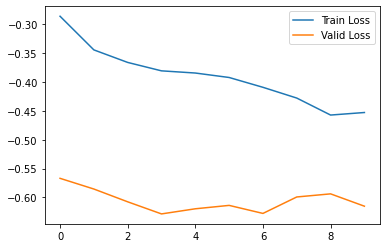

(CustomGRU(
   (gru): GRU(50, 128, num_layers=3, batch_first=True)
   (dropout): Dropout(p=0.3, inplace=False)
   (fc): Linear(in_features=128, out_features=50, bias=True)
   (activation): SiLU()
 ),
 [-0.28610648728650184,
  -0.3443837273416333,
  -0.36610647387288775,
  -0.38068188845725903,
  -0.3844615775321066,
  -0.39218915025864165,
  -0.4091987138421372,
  -0.4278328784837805,
  -0.4572540736789332,
  -0.45285207836021624],
 [-0.5668544672630927,
  -0.5853845062288078,
  -0.6075255625151299,
  -0.6284962380053225,
  -0.6196118038449738,
  -0.6137248281691526,
  -0.6276424800020619,
  -0.599141775554902,
  -0.5937580733081778,
  -0.6151239770288404])

In [21]:
# 导入必要的库
import os
import json
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import Image
# 固定随机种子以确保结果的可重复性，并进行训练和回测
os.environ["PYTHONHASHSEED"] = str(config["SEED"])  # 设置Python哈希种子
random.seed(config["SEED"])  # 设置随机种子
np.random.seed(config["SEED"])  # 设置NumPy随机种子
torch.manual_seed(config["SEED"])  # 设置PyTorch CPU随机种子
torch.cuda.manual_seed(config["SEED"])  # 设置PyTorch GPU随机种子
torch.backends.cudnn.deterministic = True  # 确保CuDNN的确定性
torch.backends.cudnn.benchmark = False  # 关闭CuDNN的自动优化
# 实例化模型训练器并准备数据
worker = ModelTrainer(config)
worker.prepare_data()
# 训练模型并可视化结果
worker.train_model(visualize=True)

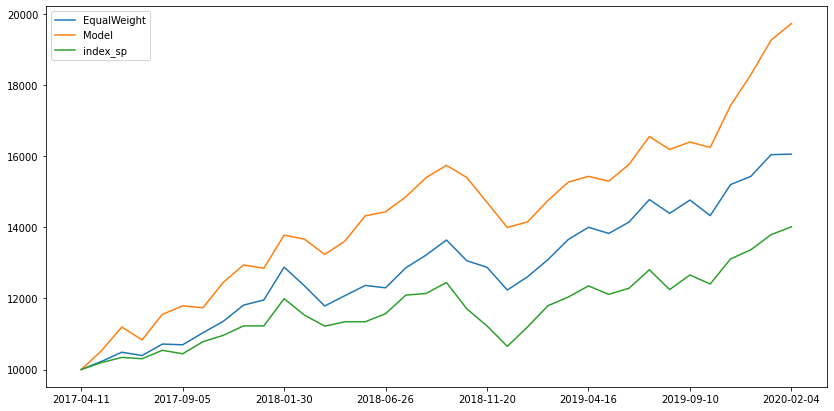

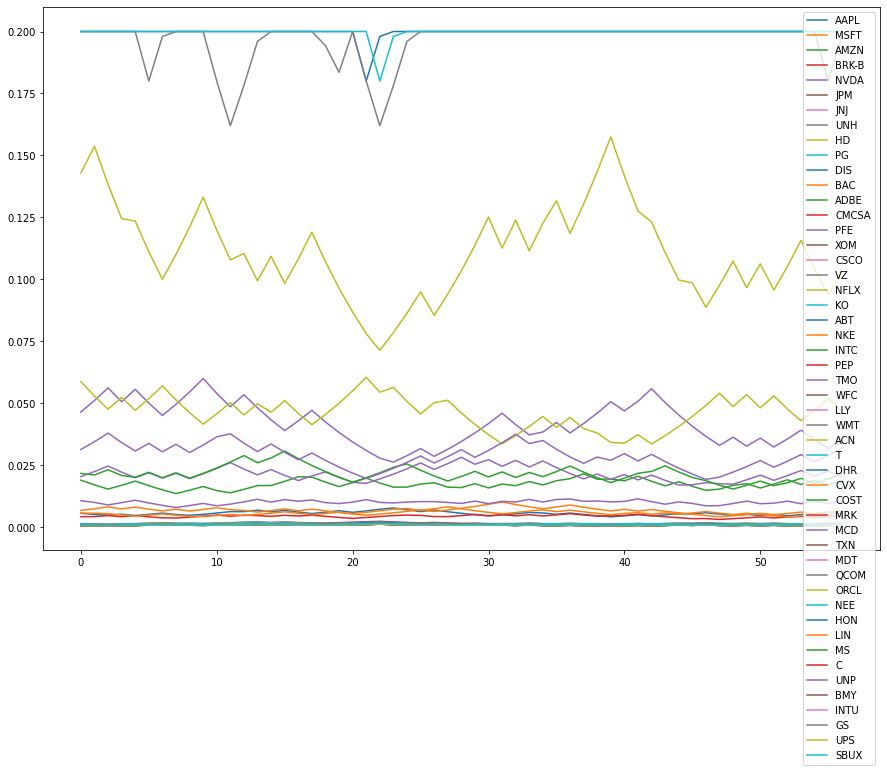

{'annualized_return': EqualWeight    0.180696
 Model          0.251189
 index_sp       0.143303
 dtype: float64,
 'annualized_volatility': EqualWeight    0.155215
 Model          0.168898
 index_sp       0.163050
 dtype: float64,
 'sharpe_ratio': EqualWeight    1.164166
 Model          1.487224
 index_sp       0.878888
 dtype: float64,
 'max_drawdown': ('index_sp', -0.23371315566995282)}

Annualized Return:
EqualWeight    0.180696
Model          0.251189
index_sp       0.143303
dtype: float64
Annualized Volatility:
EqualWeight    0.155215
Model          0.168898
index_sp       0.163050
dtype: float64
Sharpe Ratio:
EqualWeight    1.164166
Model          1.487224
index_sp       0.878888
dtype: float64
Maximum Drawdown:
('index_sp', -0.23371315566995282)


In [23]:
import pandas as pd
worker.backtest_model(visualize=True)